### Raw Operational Data from Enterprise Application
A dataset for anomaly detection in operations of distributed software systems

### Software Operational Data, Processed and Labeled
A dataset for anomaly detection in operations of distributed software systems

# Introduction
Anomaly detection has applications in many fields, such as system health monitoring, fraud detection, and intrusion detection.

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3595464%2F4088133a20318f4e47e1e2d738509d12%2F__results___5_0.png?generation=1590869249365044&alt=media)


# Approachs

In this tutorial, I  use the anomaly detection algorithm proposed in
"**A Unifying Framework for Detecting Outliers and Change Points from Time Series**", Jun-ichi Takeuchi, 2006;


### Change Finger


Our change point detection scheme in which we employ two-stage time-series learning, which we
named ChangeFinder. We illustrate ChangeFinder in Figure below. A remarkable aspect of ChangeFinder is that it repeats the
learning process twice, where the outlier detection is first done using the model learned in the first stage and change
point detection is done using the learned model in the second one.
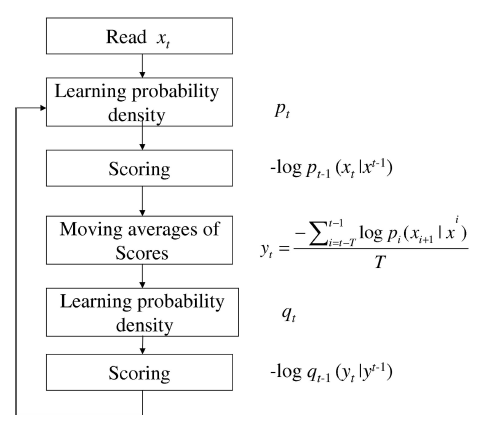

### Import Libs

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 150)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
#To plot figs on jupyter
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 14,6

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

### Test in the dataset -  Read in data.

In [ ]:
PATH =   r"/kaggle/input/features/FEATURES-2014-2015/"
df = pd.read_csv(PATH+"part-067.csv")
df.shape

# Glipse Data

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
df.dtypes

Anomaly value counts

In [ ]:
df.isAnomaly.value_counts()

In [ ]:
df[df['isAnomaly']==True].describe()

### Visualizations

In [ ]:
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)

def line_plot_check_nan(df1, df2, x, y, title, width, height):
    
    trace1 = go.Scatter(
        x = df1[x],
        y = df1[y],
        mode='lines',
        name='with_nans',
        marker = dict(
            color = '#1E90FF', 
        ), 
    )
    
    df3 = df2.dropna()
    trace2 = go.Scatter(
        x = df3[x],
        y = df3[y],
        mode='markers',
        name='no_nans',
        marker = dict(
            color = 'red', 
        ), 
    )
    
    layout = go.Layout(
        title = go.layout.Title(
            text = title,
            x = 0.5
        ),
        font = dict(size = 14),
        width = width,
        height = height,
    )
    
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = 'line_plot')

In [ ]:
line_plot_check_nan(df[df['isAnomaly']==True], df[df['isAnomaly']==True], 'timestamp', "Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))"," Memory space usage by date", 1400, 600)

In [ ]:
line_plot_check_nan(df[df['isAnomaly']==False], df[df['isAnomaly']==False], 'timestamp', "Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))"," Memory space usage by date", 1400, 600)

In [ ]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['isAnomaly'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_highr = df.loc[df['isAnomaly'] == 0, var_name].median()
    avg_lowr = df.loc[df['isAnomaly'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['isAnomaly'] == 0, var_name], label = 'isAnomaly == 0')
    sns.kdeplot(df.loc[df['isAnomaly'] == 1, var_name], label = 'isAnomaly == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for request with high runtime value = %0.4f' % avg_highr)
    print('Median value for request with low runtime value =     %0.4f' % avg_lowr)


In [ ]:
df.head(1)

Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)

In [ ]:
    
kde_target(r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', df[[r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)','isAnomaly']].dropna(),)

Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))

In [ ]:
   

kde_target(r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))', df[[r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))','isAnomaly']].dropna(),)

Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))

In [ ]:
kde_target('Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))', df[['Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))','isAnomaly']].dropna(),)

# Generic Data 
> We prepared three kinds of data sets: 1) jumping mean with constant variance, 2) jumping mean with varying variance,
and 3) jumping variance with constant mean.

- dataset 1, the Gaussian random variable have mean 0 and variance = 1 and we let a1 =0,6 and a2 = 0,5. This data
set consists of 10,000 records. Change points occur at time * 1000 (x=1,2,3...,9).

- The second data set is a data sequence such that each data between change points was drawn according to the AR model ((6), a1 = 0,6 and a2 = 0,5) in which variance
of the noise term changes gradually over time.

- The third data set is a data sequence such that at each change point, variance suddenly changes, and each data in
a range between the change points is i.i.d. (independently identically distributed).



In [ ]:
## DATASET 1
mu, sigma = 0.0, 1.0
ent1 = np.zeros((10000))
for i in range(10):
#     print(mu)
    for j in range(1000):
        ent1[1000*i+j] = np.random.normal(mu, sigma)
    mu = mu + 9 - i

a1 = 0.6
a2 = -0.5
ds1 = np.zeros((10000))
ds1[0] = ent1[0]
ds1[1] = ent1[1]
for i in range(2,10000):
    ds1[i] = a1*ds1[i-1] + a2*ds1[i-2] + ent1[i]
## DATASET 2
mu = 0.0
ent2 = np.zeros((10000))
for i in range(10):
#     print(mu)
    for j in range(1000):
        sigma = 0.1/(0.01 + (10000 - (i*1000 + j))/10000)
        ent2[1000*i+j] = np.random.normal(mu, sigma)
    mu = mu + 1

a1 = 0.6
a2 = -0.5
ds2 = np.zeros((10000))
ds2[0] = ent1[0]
ds2[1] = ent1[1]
for i in range(2,10000):
    ds2[i] = a1*ds2[i-1] + a2*ds2[i-2] + ent2[i]

## DATASET 3
mu, sigma1, sigma3 = 0.0, 1.0, 3.0
ds3 = np.zeros((10000))
for i in range(10):
    if i in {0,2,4,6,8}:
        for j in range(1000):
            ds3[1000*i+j] = np.random.normal(mu, sigma1)
    else:
        for j in range(1000):
            ds3[1000*i+j] = np.random.normal(mu, sigma3) 

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(ent1)
plt.title('Dataset 1')
plt.ylabel('Values')
plt.xlabel('Count')
plt.legend()

plt.figure(figsize=(16,4))
plt.plot(ent2)
plt.title('Dataset 2')
plt.ylabel('Values')
plt.xlabel('Count')
plt.legend()

plt.figure(figsize=(16,4))
plt.plot(ds1)
plt.title('Dataset 3')
plt.ylabel('Values')
plt.xlabel('Count')
plt.legend()

plt.figure(figsize=(16,4))
plt.plot(ds2)
plt.title('Dataset 4')
plt.ylabel('Values')
plt.xlabel('Count')
plt.legend()

plt.figure(figsize=(16,4))
plt.plot(ds3)
plt.title('Dataset 5')
plt.ylabel('Values')
plt.xlabel('Count')
plt.legend()

plt.show()

# Change Finger 
> Detecting Outliers and Change Points from Time Series


In [ ]:
!pip install changefinder
import changefinder

In [ ]:
def changeFinderALLData(data, r, order, smooth):
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    scores = [cf.update(p) for p in data]
    return scores

In [ ]:
dataplot1 = changeFinderALLData(ent1, r=0.01, order=2, smooth=5)    
dataplot2 = changeFinderALLData(ent2, r=0.01, order=3, smooth=5) 
dataplot3 = changeFinderALLData(ds1, r=0.01, order=2, smooth=5)    
dataplot4 = changeFinderALLData(ds2, r=0.01, order=3, smooth=5)        
dataplot5 = changeFinderALLData(ds3, r=0.02, order=3, smooth=5) 

In [ ]:
dataCHANGEFINGER_dataset1 = np.array(dataplot1)
from scipy import stats
dataCHANGEFINGER_dataset1 = stats.describe(dataplot1)
dataCHANGEFINGER_dataset1

In [ ]:
qt25_ds1 = np.percentile(dataplot1, 25)  # Q1
qt50_ds1 = np.percentile(dataplot1, 50)  # Q2
qt75_ds1 = np.percentile(dataplot1, 75)  # Q3
qt25_ds1,qt50_ds1, qt75_ds1

In [ ]:
dfCHANGEFINGER_dataset1 = pd.DataFrame(dataplot1, columns=['Score'])

Plot / Threashold in 75% Quartil

In [ ]:
def plot_anomaly_score_low_higt(datascore, data):
    datascore_ = np.array(datascore)
    from scipy import stats
    datascore_ = stats.describe(datascore)
    
    datascore_ = pd.DataFrame(datascore, columns=['Score'])

    delta = np.percentile(datascore, 75)
    print('Threashold ',delta)

    plt.figure(figsize=(16,6))
    plt.plot(data)
    plt.title("data count")        

    plt.figure(figsize=(16,6))
    plt.plot(datascore)
    plt.title("data count")        

    
    plt.figure(figsize=(16,6))
    df_high_data_ = datascore_[datascore_ <= delta]
    df_high_score_ = datascore_[datascore_ > delta]
    
    plt.plot(datascore_.index, datascore_.Score.fillna(1), c='gray', alpha=0.4)
    plt.scatter(df_high_data_.index, df_high_data_.values, label='Inline', s=10)
    plt.scatter(df_high_score_.index, df_high_score_.values, label='Outlier', c='red', s=10)
    plt.margins(x=0.01,y=0.2)
    plt.title('Anomaly Score ')
    plt.ylabel('Score')
    plt.xlabel('Data Count')
    plt.legend()
    plt.show()

### df CHANGEFINGER dataset1

In [ ]:
plot_anomaly_score_low_higt(dataplot1, ent1)

In [ ]:
plot_anomaly_score_low_higt(dfCHANGEFINGER_dataset1, ent1)

### df CHANGEFINGER dataset2

In [ ]:
dataCHANGEFINGER_dataset2 = np.array(dataplot2)
from scipy import stats
dataCHANGEFINGER_dataset2 = stats.describe(dataplot2)
dataCHANGEFINGER_dataset2

In [ ]:
qt25_ds2 = np.percentile(dataplot2, 25)  # Q1
qt50_ds2 = np.percentile(dataplot2, 50)  # Q2
qt75_ds2 = np.percentile(dataplot2, 75)  # Q3
qt25_ds2,qt50_ds2, qt75_ds2

In [ ]:
dfCHANGEFINGER_dataset2 = pd.DataFrame(dataplot2, columns=['Score'])

Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dfCHANGEFINGER_dataset2, ent2)

### df CHANGEFINGER dataset 3

In [ ]:
dataCHANGEFINGER_dataset3 = np.array(dataplot3)
from scipy import stats
dataCHANGEFINGER_dataset3 = stats.describe(dataplot3)
dataCHANGEFINGER_dataset3

In [ ]:
qt25_ds3 = np.percentile(dataplot3, 25)  # Q1
qt50_ds3 = np.percentile(dataplot3, 50)  # Q2
qt75_ds3 = np.percentile(dataplot3, 75)  # Q3
qt25_ds3,qt50_ds3, qt75_ds3

In [ ]:
dfCHANGEFINGER_dataset3 = pd.DataFrame(dataplot3, columns=['Score'])


Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dfCHANGEFINGER_dataset3, ds1)


### df CHANGEFINGER dataset4

In [ ]:
dataCHANGEFINGER_dataset4 = np.array(dataplot4)
from scipy import stats
dataCHANGEFINGER_dataset4 = stats.describe(dataplot4)
dataCHANGEFINGER_dataset4

In [ ]:
qt25_ds4 = np.percentile(dataplot4, 25)  # Q1
qt50_ds4 = np.percentile(dataplot4, 50)  # Q2
qt75_ds4 = np.percentile(dataplot4, 75)  # Q3
qt25_ds4, qt50_ds4, qt75_ds4

In [ ]:
dfCHANGEFINGER_dataset4 = pd.DataFrame(dataplot4, columns=['Score'])

Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dfCHANGEFINGER_dataset4, ds2)

### df CHANGEFINGER dataset5

In [ ]:

dataCHANGEFINGER_dataset5 = np.array(dataplot5)
from scipy import stats
dataCHANGEFINGER_dataset5 = stats.describe(dataplot5)
dataCHANGEFINGER_dataset5

In [ ]:

qt25_ds5 = np.percentile(dataplot5, 25)  # Q1
qt50_ds5 = np.percentile(dataplot5, 50)  # Q2
qt75_ds5 = np.percentile(dataplot5, 75)  # Q3
qt25_ds5, qt50_ds5, qt75_ds5

In [ ]:
dfCHANGEFINGER_dataset5 = pd.DataFrame(dataplot5, columns=['Score'])


Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dfCHANGEFINGER_dataset5, ds3)

# Anomaly Detection - Thread CPU time, Memory space usage.

In [ ]:
from scipy.stats import norm, skew

In [ ]:
(mu, sigma) = norm.fit(df.loc[df['isAnomaly'] == 1, r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))'])
print(
    'Memory space usage : anomaly {:.1f} and standard deviation = {:.1f}'.format(mu, sigma))

In [ ]:
(mu, sigma) = norm.fit(df.loc[df['isAnomaly'] == 1, r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'])
print(
    'Thread CPU time : anomaly {:.1f} and standard deviation = {:.1f}'.format(mu, sigma))

# KDE - Thread CPU time

Let's create a kernel density estimation (KDE) plot colored by the **Thread CPU time** of the **Anomaly**. A kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. It will allow us to identify if there is a correlation between the **Thread CPU time** and **Anomaly**.

In [ ]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['isAnomaly'] == 0, r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'], label = 'Inline')
sns.kdeplot(df.loc[df['isAnomaly'] == 1, r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'], label = 'Outlier')
plt.xlabel('Thread CPU time anomaly analysis')
plt.xlim(left=0)
plt.ylabel('Density')
plt.title('Thread CPU time Distribution in Percent by Anomaly Event');

# KDE - Memory space usage

Let's create a kernel density estimation (KDE) plot colored by the **Memory space usage** of the **Anomaly**. A kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. It will allow us to identify if there is a correlation between the **Memory space usage** and **Anomaly**.

In [ ]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['isAnomaly'] == 0, r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))'], label = 'Inline')
sns.kdeplot(df.loc[df['isAnomaly'] == 1, r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))'], label = 'Outlier')
plt.xlabel('Memory space usage anomaly analysis')
plt.xlim(left=0)
plt.ylabel('Density')
plt.title('Memory space usage Distribution in Percent by Anomaly Event');

In [ ]:


df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==1].head()  




Thread CPU time

In [ ]:
df[r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'].value_counts()

Memory space usage

In [ ]:
df['Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))'].value_counts()

In [ ]:
dataplot_ThreadCPUtime = changeFinderALLData(df[[r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']].values, r=0.01, order=1, smooth=5)    
# dataplot_ThreadCPUtime

In [ ]:
dataplot_memoryspaceusage = changeFinderALLData(df[['Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']].values, r=0.01, order=1, smooth=5)    
# dataplot_memoryspaceusage

### df CHANGEFINGER Memory Space Usage 


In [ ]:

dataCHANGEFINGER_memoryspaceusage = np.array(dataplot_memoryspaceusage)
from scipy import stats
dataCHANGEFINGER_memoryspaceusage = stats.describe(dataplot_memoryspaceusage)
dataCHANGEFINGER_memoryspaceusage


In [ ]:
qt25_memoryusage = np.percentile(dataplot_memoryspaceusage, 25)  # Q1
qt50_memoryusage = np.percentile(dataplot_memoryspaceusage, 50)  # Q2
qt75_memoryusage = np.percentile(dataplot_memoryspaceusage, 75)  # Q3
qt25_memoryusage, qt50_memoryusage, qt75_memoryusage
dataCHANGEFINGER_memoryspaceusage = pd.DataFrame(dataplot_memoryspaceusage, columns=['Score'])


# Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dataplot_memoryspaceusage, df[['Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']].values)

In [ ]:
# df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==1][ r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']
# df_high_data_
# df.timestamp.values

Memory space usage

In [ ]:
plt.figure(figsize=(16,6))
df_high_data_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==1][ r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']
df_high_score_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==0][ r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']

    
plt.plot(df.index, df.isAnomaly.fillna(1), c='gray', alpha=0.4)
plt.scatter(df_high_data_.index, df_high_data_.values, label='Inline', s=30)
plt.scatter(df_high_score_.index, df_high_score_.values, label='Outlier', c='red', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Values Grand truth ')
plt.ylabel('Values')
plt.xlabel('Data Count')
plt.legend()
plt.show()


### df CHANGEFINGER Memory Space Usage 


In [ ]:
dataCHANGEFINGER_ThreadCPUtime = np.array(dataplot_ThreadCPUtime)
from scipy import stats
dataCHANGEFINGER_ThreadCPUtime = stats.describe(dataplot_ThreadCPUtime)
dataCHANGEFINGER_ThreadCPUtime


In [ ]:
qt25_ThreadCPUtime = np.percentile(dataplot_ThreadCPUtime, 25)  # Q1
qt50_ThreadCPUtime = np.percentile(dataplot_ThreadCPUtime, 50)  # Q2
qt75_ThreadCPUtime = np.percentile(dataplot_ThreadCPUtime, 75)  # Q3
qt25_ThreadCPUtime, qt50_ThreadCPUtime, qt75_ThreadCPUtime
dataCHANGEFINGER_ThreadCPUtime = pd.DataFrame(dataplot_ThreadCPUtime, columns=['Score'])


# Plots/ Threashold in 75%  Quartil

In [ ]:
plot_anomaly_score_low_higt(dataplot_ThreadCPUtime, df[['Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']].values)

Thread CPU time

In [ ]:
plt.figure(figsize=(16,6))
df_high_data_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==1][ r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']
df_high_score_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==0][ r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']

    
plt.plot(df.index, df.isAnomaly.fillna(1), c='gray', alpha=0.4)
plt.scatter(df_high_data_.index, df_high_data_.values, label='Inline', s=40)
plt.scatter(df_high_score_.index, df_high_score_.values, label='Outlier', c='red', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Values Grand truth ')
plt.ylabel('Values')
plt.xlabel('Data Count')
plt.legend()
plt.show()

# Propeth Anomaly Detection

> see this: (Anomaly detection in time series with Prophet library)[https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f]

In [ ]:
!pip install fbprophet
from fbprophet import Prophet
import os

In [ ]:
# View the data as a table
df_ = pd.DataFrame(df, columns=['timestamp', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'])
df_['ds']=df_['timestamp']
df_['y']=df_[r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'].astype(float)
df_=df_.drop(['timestamp',r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)'],axis=1)
df_.head()

Propeth Prediction

In [ ]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
#                 seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(df_)

In [ ]:
pred.tail()

### Detecting Anomalies:
- The light blue boundaries in the above graph are yhat_upper and yhat_lower.
- If y value is greater than yhat_upper and less than yhat lower then it is an anomaly.
- Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower.

Detect Anomalies

In [ ]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1 #-1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [ ]:
pred.head()

In [ ]:
pred[ r'anomaly'].value_counts()

In [ ]:
plt.figure(figsize=(16,6))
df_outlier_ = pred[[r'ds','anomaly', r'yhat']][pred['anomaly']==1][ r'yhat']
# df_outlier = pred[[r'ds','anomaly', r'yhat']][pred['anomaly']==-1][ r'yhat']

df_inline_ = pred[[r'ds','anomaly', r'yhat']][pred['anomaly']==0][ r'yhat']

plt.plot(pred.index, pred.anomaly.fillna(1), c='gray', alpha=0.4)
plt.scatter(df_inline_.index, df_inline_.values, label='Inline', s=40)
plt.scatter(df_outlier_.index, df_outlier_.values, label='Outlier', c='red', s=10)
# plt.scatter(df_outlier.index, df_outlier.values, label='Outlier', c='black', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Values Grand truth ')
plt.ylabel('Values')
plt.xlabel('Data Count')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
df_high_data_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==1][ r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']
df_high_score_ = df[[r'timestamp','isAnomaly', r'Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)', r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']][df['isAnomaly']==0][ r'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))']

    
plt.plot(df.index, df.isAnomaly.fillna(1), c='gray', alpha=0.4)
plt.scatter(df_high_data_.index, df_high_data_.values, label='Inline', s=30)
plt.scatter(df_high_score_.index, df_high_score_.values, label='Outlier', c='red', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Values Grand truth ')
plt.ylabel('Values')
plt.xlabel('Data Count')
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Thread CPU time results

In [ ]:
trace = go.Scatter(
        name = 'Thread CPU time',
       mode = 'markers',
       x = list(df['timestamp']),
       y = list(df['Thread CPU time : (MXBean(java.lang:type=Threading).CurrentThreadCpuTime)']),
       marker=dict(
              color='#FFBAD2',
              line=dict(width=1)
       )
)
trace1 = go.Scatter(
    name = 'trend',
       mode = 'lines',
       x = list(pred['ds']),
       y = list(pred['yhat']),
       marker=dict(
              color='red',
              line=dict(width=1)
       )
)
upper_band = go.Scatter(
    name = 'upper band',
        mode = 'lines',
        x = list(pred['ds']),
        y = list(pred['yhat_upper']),
        line= dict(color='#57b88f'),
        fill = 'tonexty'
)
lower_band = go.Scatter(
    name= 'lower band',
        mode = 'lines',
        x = list(pred['ds']),
        y = list(pred['yhat_lower']),
        line= dict(color='#1705ff')
)
data = [trace, trace1, lower_band, upper_band]
layout = dict(title='Thread CPU time Estimation',
             xaxis=dict(title = 'Dates', ticklen=2, zeroline=False))
figure=dict(data=data,layout=layout)

In [ ]:
py.offline.iplot(figure)

In [ ]:
# import os 
# inputFolder = '../input/' 
# for root, directories, filenames in os.walk(inputFolder): 
#     for filename in filenames: print(os.path.join(root,filename))

# Remember the upvote button is next to the fork button, and it's free too! ;)

### Don't hesitate to give your suggestions in the comment section

## End Notebook